# Brain Tumor Detection
---
---

# <a id='env'># Setting up the Environment</a>

In [1]:
from convolution import Convolution as conv
from dilation import Dilation
from erosion import Erosion
from rgb_to_gray import RgbToGray
from threshold import Threshold

In [2]:
import numpy as np
from tqdm import tqdm
import cv2
import shutil
import itertools
import imutils
import os

In [3]:
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
import seaborn as sns; sns.set()

In [4]:
RANDOM_SEED = 123

IMG_SIZE = (224, 224)

RAW_DATASET_PATH = 'dataset_MRI_brain_raw'

TEST_PATH = os.path.join('dataset_brain_mri', 'TEST')
TRAIN_PATH = os.path.join('dataset_brain_mri', 'TRAIN')
VALID_PATH = os.path.join('dataset_brain_mri', 'VALID')

TRAIN_CROP_PATH = os.path.join('dataset_brain_mri_cropped', 'TRAIN')
TEST_CROP_PATH = os.path.join('dataset_brain_mri_cropped', 'TEST')
VALIDATION_CROP_PATH = os.path.join('dataset_brain_mri_cropped', 'VALID')

#### Setting up the Dataset

In [5]:
for CLASS in os.listdir(RAW_DATASET_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(os.path.join(RAW_DATASET_PATH, CLASS)))
        for (n, FILE_NAME) in enumerate(os.listdir(os.path.join(RAW_DATASET_PATH, CLASS))):
            img = os.path.join(RAW_DATASET_PATH, CLASS, FILE_NAME)
            if n < 10:
                shutil.copy(img, os.path.join(TEST_PATH, CLASS.upper(), FILE_NAME))
            elif n < 0.85*IMG_NUM:
                shutil.copy(img, os.path.join(TRAIN_PATH, CLASS.upper(), FILE_NAME))
            else:
                shutil.copy(img, os.path.join(VALID_PATH, CLASS.upper(), FILE_NAME))

# <a id='import'># Data Import and Preprocessing</a>

#### Load Dataset as ndarrays

In [6]:
def load_data(dir_path):
    """
    Load and resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = {}
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(dir_path, path, file))
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    
    return X, y, labels

In [7]:
X_train, y_train, labels = load_data(TRAIN_PATH)
X_test, y_test, _ = load_data(TEST_PATH)
X_val, y_val, _ = load_data(VALID_PATH)

100%|██████████| 2/2 [00:00<00:00, 17.14it/s]


196 images loaded from dataset_brain_mri\TRAIN directory.
20 images loaded from dataset_brain_mri\TEST directory.
37 images loaded from dataset_brain_mri\VALID directory.


#### Dataset Exploration Analysis

In [8]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [9]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desire number of image (n) from the spesified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)
        
        plt.figure(figsize = (15, 6))
        c = 1
        for img in imgs:
            plt.subplot(i , j, c)
            plt.imshow(img[0])
            
            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

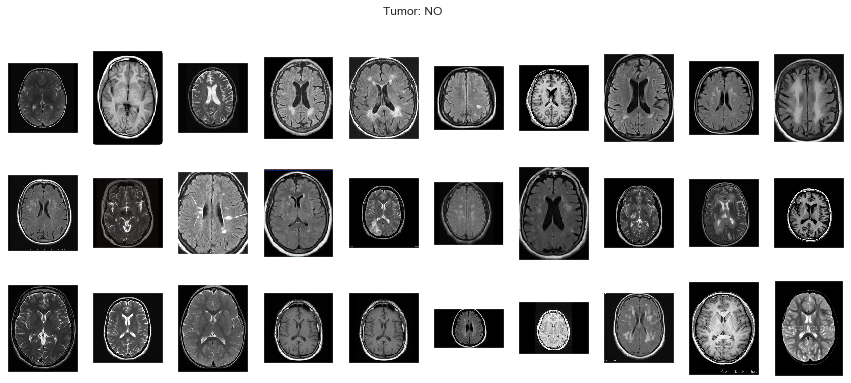

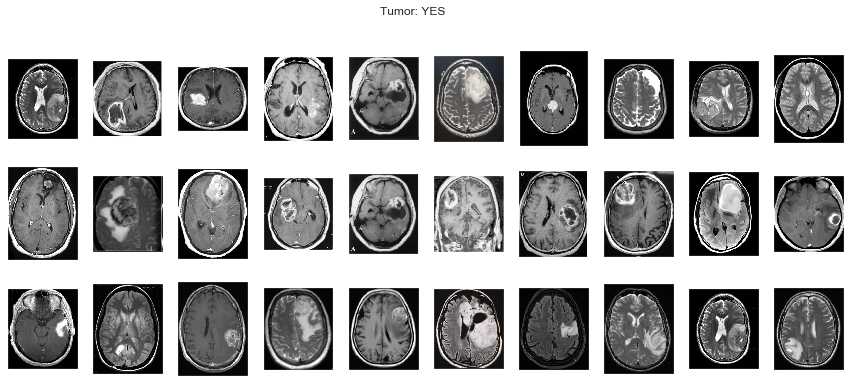

In [10]:
plot_samples(X_train, y_train, labels, 30)

In [11]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    i = 1
    for img in set_name:
        print(i)
        i += 1
        gray = RgbToGray(img).run1()
        gray = conv(gray, 'gaussian5').run()

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = Threshold(gray).run()
        thresh = Erosion(thresh).run()
        thresh = Erosion(thresh).run()
        thresh = Dilation(thresh).run()
        thresh = Dilation(thresh).run()

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

#### Crop Image Example

In [12]:
img = cv2.imread(os.path.join(RAW_DATASET_PATH, 'yes', 'Y108.jpg'))
img = cv2.resize(
    img,
    dsize = IMG_SIZE,
    interpolation = cv2.INTER_CUBIC
)
gray = RgbToGray(img).run1()
gray = conv(gray, 'gaussian5').run()

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = Threshold(gray).run()
thresh = Erosion(thresh).run()
thresh = Erosion(thresh).run()
thresh = Dilation(thresh).run()
thresh = Dilation(thresh).run()

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

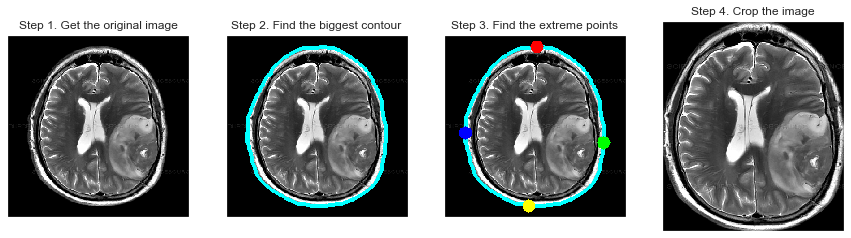

In [13]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [14]:
# apply crop_imgs
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


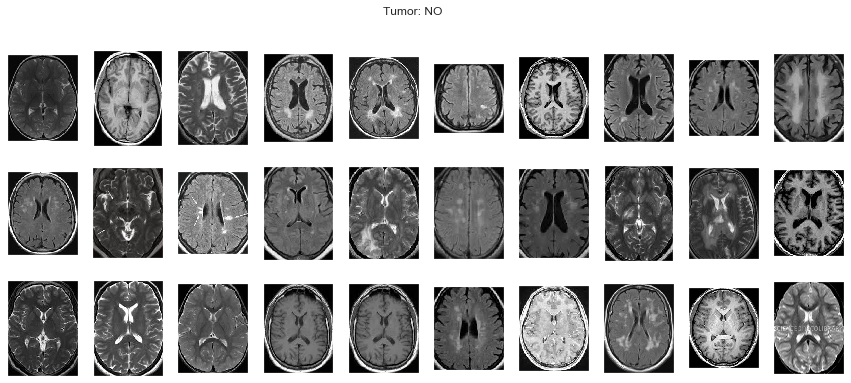

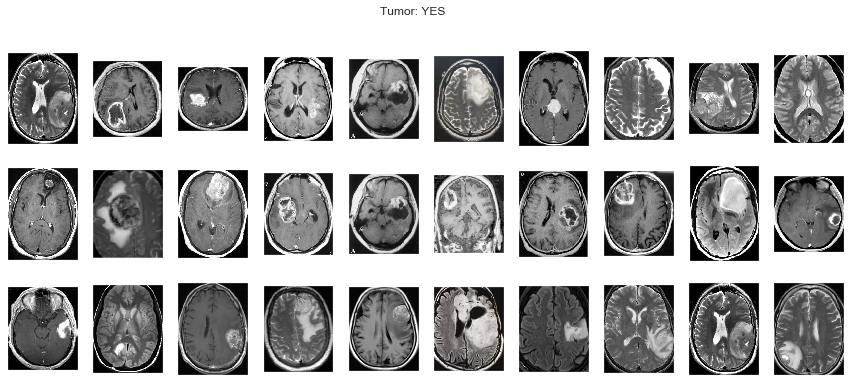

In [15]:
plot_samples(X_train_crop, y_train, labels, 30)

#### Save Cropped Images

In [16]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imgclass) in zip(x_set, y_set):
        if imgclass == 0:
            cv2.imwrite(os.path.join(folder_name, 'NO', str(i)+'.jpg'), img)
        else:
            cv2.imwrite(os.path.join(folder_name, 'YES', str(i)+'.jpg'), img)
        i += 1

In [17]:
save_new_images(X_train_crop, y_train, TRAIN_CROP_PATH)
save_new_images(X_val_crop, y_val, VALIDATION_CROP_PATH)
save_new_images(X_test_crop, y_test, TEST_CROP_PATH)